In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import os
# x, y = [] , []


# for index, (dirname, _, filenames) in enumerate(os.walk('/kaggle/input/test')):
#     for filename in filenames:
#         file = os.path.join(dirname, filename)
#         img = plt.imread(file) / 256
#         expression = dirname.split('/')[-1]
#         x.append(img)
#         y.append(expression)

#         print(file, expression)
#         plt.figure(index, figsize=(4,4))
#         plt.subplot(1,1,1)
#         plt.imshow(img)
#         plt.show()
#         break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

To extract the labels for y

In [58]:
images = ImageFolder('./data/train/', transform=ToTensor())

In [39]:
loader = Data.DataLoader(images), shuffle=True, batch_size=64,)

torch.Size([64, 3, 48, 48]) tensor(5)


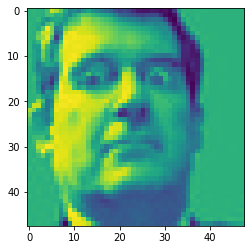

In [40]:
data = iter(loader)
x, y = data.next()
# u = torch.reshape(x, (64, 1, 48,48))
ind = 5
print(x.shape, y[ind])
plt.imshow(x[0][0])

In [61]:
images[0][1]

0

In [41]:
def prepare_labels():
    y_labels = {}
    for index, dirname in enumerate(sorted(os.listdir('./data/train/'))):
        y_labels[index] = dirname
    return y_labels

In [42]:
label_dict = prepare_labels()

In [43]:
label_dict

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [44]:
# def get_expression_key(val):
#     for key, value in label_dict.items():
#         if value == val:
#             return key

In [45]:
# for index, (dirname, _, filenames) in enumerate(os.walk('./data/train/')):
#     for filename in filenames:
#         file = os.path.join(dirname, filename)
#         img = plt.imread(file) / 256
#         expression = dirname.split('/')[-1]
#         x.append(img)
#         y.append(get_expression_key(expression))

In [46]:
print(len(x), len(y))

64 64


In [47]:
# x = torch.tensor(x, dtype=torch.float32)[:, None, :, :]
# y = torch.tensor(y)

In [48]:
print(x.shape, y.shape)
print(x.dtype, y.dtype)

torch.Size([64, 3, 48, 48]) torch.Size([64])
torch.float32 torch.int64


In [49]:
# torch_dataset = Data.TensorDataset(x,y)

In [50]:
# torch_loader = Data.DataLoader(torch_dataset, shuffle=True, batch_size=64)

In [51]:
# data = iter(torch_loader)
# x, y = data.next()

In [52]:
x.shape

torch.Size([64, 3, 48, 48])

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer1 = nn.Linear(4608, 700)
        self.layer2 = nn.Linear(700, 7)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [54]:
net = Net()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.02)

In [55]:
def train(dataloader, model, loss_fn, optim):
    size = len(dataloader.dataset)
    model.train()
    for step, (x, y) in enumerate(dataloader):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        if step % 100 == 0:
            loss, current = loss.item(), step * len(x)
            print( f'loss {loss:>7f} {current:>5d}/{size:>5d}')


In [56]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x,y in dataloader:
            y_pred = model(x)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f'test error \n acc {(100*correct):>0.1f}% avg_loss {test_loss:>8f} \n')

In [57]:
EPOCH = 5
for i in range(EPOCH):
    print(f'EPOCH {i+1}')
    train(loader, net, loss_fn, optim)

EPOCH 1
loss 1.956060     0/28709
loss 1.825337  6400/28709
loss 1.801237 12800/28709
loss 1.883385 19200/28709
loss 1.820924 25600/28709
EPOCH 2
loss 1.841486     0/28709
loss 1.813631  6400/28709
loss 1.758719 12800/28709
loss 1.790718 19200/28709
loss 1.858788 25600/28709
EPOCH 3
loss 1.759409     0/28709
loss 1.795614  6400/28709
loss 1.855366 12800/28709
loss 1.764685 19200/28709
loss 1.828550 25600/28709
EPOCH 4
loss 1.869631     0/28709
loss 1.834634  6400/28709
loss 1.780120 12800/28709
loss 1.889315 19200/28709
loss 1.857541 25600/28709
EPOCH 5
loss 1.820787     0/28709
loss 1.850049  6400/28709
loss 1.836069 12800/28709
loss 1.847309 19200/28709
loss 1.936316 25600/28709


original ->  angry | prediction ->  sad


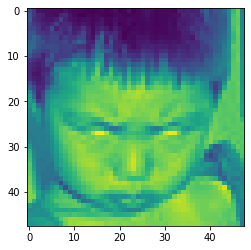

In [67]:
testx, testy= images[0]
np_testx = testx[0].numpy()
plt.imshow(np_testx)
test_pred_y = net(testx[None,...])
argmax_pred_y = torch.argmax(test_pred_y)
print('original -> ',label_dict[testy], '| prediction -> ',label_dict[argmax_pred_y.item()])